In [33]:
import os

from collections import defaultdict

import math

import networkx as nx

import random

from tqdm import tqdm

from zipfile import ZipFile

from urllib.request import urlretrieve

import numpy as np

import pandas as pd

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [ ]:
urlretrieve( "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip")

ZipFile("movielens.zip", "r").extractall()

In [10]:
# Load movies to a DataFrame

movies = pd.read_csv("ml-latest-small/movies.csv")

# Create a `movieId` string

movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame

ratings = pd.read_csv("ml-latest-small/ratings.csv") 

# Convert the `ratings` to floating point

ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Create the `movie_id` string

ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)

print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [11]:
# This function gives us the name of the movie from the movieId
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]  

# This function gives us the id of the movie from the name of the movie
def get_movie_id_by_title(title):

    return list(movies[movies.title == title].movieId)[0]

In [12]:
# Let's look at the datasets
ratings.head() 

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [13]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


In [14]:
min_rating = 5

item_frequency = defaultdict(int)  # Dictionary to indicate how many times each movie has been watched

pair_frequency = defaultdict(int)  # Dictionary to indicate how many times a particular pair of movies have been watched

# Filter instances where the rating is greater than or equal to min_rating

rated_movies = ratings[ratings.rating >= min_rating]

# Group instances by the user. Here, each group contains movies watched by a particular user

movies_grouped_by_users = list(rated_movies.groupby("userId"))

for group in tqdm(
    
    movies_grouped_by_users,
    
    position = 0,

    leave = True,

    desc = "Compute movie rating frequencies",):  # Iterating over all the groups

    # Get a list of movies rated by the user

    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):

        item_frequency[current_movies[i]] += 1  # Increasing count of item frequency for a particular movie on encountering it in a group
        
        for j in range(i + 1, len(current_movies)):
            
            x = min(current_movies[i], current_movies[j])
            
            y = max(current_movies[i], current_movies[j])
            
            pair_frequency[(x, y)] += 1  # Increasing count of pair frequency for a particular pair of movies on coming across it

Compute movie rating frequencies: 100%|████████████████████████████████████████████| 573/573 [00:00<00:00, 1434.10it/s]


In [15]:
min_weight = 10

D = math.log(sum(item_frequency.values()))

# Create the undirected graph with the movies as nodes

movies_graph = nx.Graph()

# Add weighted edges between movies

# This automatically adds the movie nodes to the graph

for pair in tqdm(pair_frequency, position = 0, leave = True, desc = "Creating the movie graph"):  # Iterating over every pair of movies
    x, y = pair  # Unpacking the tuple called 'pair' to receive the two movies

    
    xy_frequency = pair_frequency[pair]  # Pair-wise frequency of two particular movies
    
    x_frequency = item_frequency[x]  # Item frequency for the first movie in the pair
    
    y_frequency = item_frequency[y]  # Item frequency for the second movie in the pair

    # Calculating PMI index as a measure of the pairing strength

    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D

    weight = pmi * xy_frequency

    # Only include edges with weight >= min_weight

    if weight >= min_weight:

        movies_graph.add_edge(x, y, weight = weight)  # Adding the edge to those particular nodes

Creating the movie graph: 100%|████████████████████████████████████████████| 298586/298586 [00:00<00:00, 744227.33it/s]


In [16]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())

print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


In [17]:
degrees = []

for node in movies_graph.nodes:
    
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 57.0


In [18]:
vocabulary = ["NA"] + list(movies_graph.nodes)

vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [19]:
def next_step(graph, previous, current, p, q):

    neighbors = list(graph.neighbors(current))

    weights = []

    # Adjust the weights of the edges to the neighbors with the help of p and q so that we can control or give a preference to which category of nodes we would want to visit next

    for neighbor in neighbors: # Looping through all the neighbors

        if neighbor == previous:

            # Control the probability to return to the previous node

            weights.append(graph[current][neighbor]["weight"] / p)

        elif graph.has_edge(neighbor, previous):

            # The probability of visiting a local node

            weights.append(graph[current][neighbor]["weight"])

        else:

            # Control the probability to move forward

            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor

    weight_sum = sum(weights)

    probabilities = [weight / weight_sum for weight in weights]

    # Probabilistically select a neighbor to visit

    next = np.random.choice(neighbors, size = 1, p = probabilities)[0]
    
    return next

In [20]:
def random_walk(graph, num_walks, num_steps, p, q):

    walks = []

    nodes = list(graph.nodes())

    # Perform multiple iterations of the random walk

    for walk_iteration in range(num_walks):

        random.shuffle(nodes)

        for node in tqdm(
            
            nodes,

            position = 0,

            leave = True,

            desc = f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph

            walk = [node]

            # Randomly walk for num_steps by calling the next_step function we created above
            
            while len(walk) < num_steps:
                
                current = walk[-1]  # Current node is the last element of the array 'walk'
                
                previous = walk[-2] if len(walk) > 1 else None  # If the length of our array 'walk' is more than one, then the previous node is the second last element of the array 'walk'
                
                next = next_step(graph, previous, current, p, q)  # Compute the next node to visit
                
                walk.append(next)  # Append the next node obtained to the array 'walk'

            # Replace node ids (movieId) in the walk with token ids by looking at the vocabulary lookup

            walk = [vocabulary_lookup[token] for token in walk]

            # Add the walk to the generated sequence
            
            walks.append(walk)

    return walks

In [21]:
# Random walk return parameter

p = 2

# Random walk in-out parameter

q = 1.5

# Number of iterations of random walks

num_walks = 5

# Number of steps of each random walk

num_steps = 10

walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))


Random walks iteration 5 of 5: 100%|██████████████████████████████████████████████| 1405/1405 [00:03<00:00, 427.01it/s]

Number of walks generated: 7025


In [22]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):

    example_weights = defaultdict(int)
    
    # Iterate over all sequences (walks)

    for sequence in tqdm(
        
        sequences,

        position = 0,

        leave = True,

        desc = f"Generating postive and negative examples",
    ):
        
        # Generate positive and negative skipgram pairs for a sequence or walk
        
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            
            sequence,

            vocabulary_size = vocabulary_size,

            window_size = window_size,

            negative_samples = num_negative_samples,

        )
        for idx in range(len(pairs)):  # Iterating through all pairs received from the skipgram function

            pair = pairs[idx]  # Extracting the pair of movies

            label = labels[idx]  # Extracting the labels

            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])

            if target == context:
             
                continue

            if(label == 1):  # If a positive sample is generated we label them 1, otherwise we label them 0  
                
                previous_negative_label = 0

                previous_negative_entry = (target, context, previous_negative_label)

                example_weights[previous_negative_entry] = 0  # Making the previous entry of the negative sample equal to zero because we have a positive sample now
                
                entry = (target, context, label)
                
                example_weights[entry] += 1
            
            if(label == 0):  # If a negative sample is generated
                
                querylabel = 1
                
                queryentry = (target, context, querylabel)  # We check if a positive sample with the same pair of movies exist   
                
                if ( example_weights[queryentry]>0):
                
                    continue  # We skip adding this entry to our entry if already a positive sample exists
             
                else:
             
                    entry = (target, context, label)
             
                    example_weights[entry] +=1  # If a positive sample doesn't exist, we add the negative example

    targets, contexts, labels, weights = [], [], [], []

    for entry in example_weights:
    
        weight = example_weights[entry]
    
        if(weight > 0):

            target, context, label = entry  # Tuple unpacking of the 'entry' tuple
            
            targets.append(target)
            
            contexts.append(context)
            
            labels.append(label)
            
            weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4

targets, contexts, labels, weights = generate_examples(

    sequences = walks,

    window_size = num_steps,
    
    num_negative_samples = num_negative_samples,

    vocabulary_size = len(vocabulary),
    
)

Generating postive and negative examples: 100%|███████████████████████████████████| 7025/7025 [00:07<00:00, 910.33it/s]


In [23]:
print(f"Targets shape: {targets.shape}")

print(f"Contexts shape: {contexts.shape}")

print(f"Labels shape: {labels.shape}")

print(f"Weights shape: {weights.shape}")


Targets shape: (728924,)
Contexts shape: (728924,)
Labels shape: (728924,)
Weights shape: (728924,)


In [24]:
batch_size = 1024

def create_dataset(targets, contexts, labels, weights, batch_size):

    inputs = {

        "target": targets,

        "context": contexts,

    }  # Pre-processing the targets, contexts, and labels vectors to fit our Neural Network pipeline 
    
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    
    dataset = dataset.shuffle(buffer_size = batch_size * 2)  # Shuffling the data set to remove any chance of sequential data
    
    dataset = dataset.batch(batch_size, drop_remainder = True)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)
 
    return dataset


dataset = create_dataset(

    targets = targets,

    contexts = contexts,

    labels = labels,
    
    weights = weights,
    
    batch_size = batch_size,
)


In [25]:
learning_rate = 0.001

embedding_dim = 50

num_epochs = 10

In [26]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {

        "target": layers.Input(name = "target", shape = (), dtype = "int32"),

        "context": layers.Input(name = "context", shape = (), dtype = "int32"),

    }
    # Initialize item embeddings
    
    embed_item = layers.Embedding(
    
        input_dim = vocabulary_size,
        
        output_dim = embedding_dim,
        
        embeddings_initializer = "he_normal",
        
        embeddings_regularizer = keras.regularizers.l2(1e-6),
        
        name="item_embeddings",
    )
    
    # Lookup embeddings for the target

    target_embeddings = embed_item(inputs["target"])
    
    # Lookup embeddings for the context
    
    context_embeddings = embed_item(inputs["context"])
    
    # Compute dot similarity between target and context embeddings
    
    logits = layers.Dot(axes = 1, normalize = False, name = "dot_similarity")(
        
        [target_embeddings, context_embeddings]
    )

    # Create the model
    
    model = keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [27]:
model = create_model(len(vocabulary), embedding_dim)

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate),

    loss = keras.losses.BinaryCrossentropy(from_logits = True),

)  # Setting up the model's optimizers

In [28]:
!pip install pydot

     ---------------------------------------- 0.0/102.6 kB ? eta -:--:--
     -------------------------------------  102.4/102.6 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 102.6/102.6 kB 2.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\USER\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [37]:
keras.utils.plot_model(model, show_shapes = True, show_dtype = True, show_layer_names = True,)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
history = model.fit(dataset, epochs = num_epochs)

Epoch 1/10
711/711 [==============================] - 3s 4ms/step - loss: 2.1073
Epoch 2/10
711/711 [==============================] - 3s 4ms/step - loss: 1.7555
Epoch 3/10
711/711 [==============================] - 3s 4ms/step - loss: 1.6908
Epoch 4/10
711/711 [==============================] - 3s 4ms/step - loss: 1.6592
Epoch 5/10
711/711 [==============================] - 3s 4ms/step - loss: 1.6394
Epoch 6/10
711/711 [==============================] - 3s 4ms/step - loss: 1.6252
Epoch 7/10
711/711 [==============================] - 3s 4ms/step - loss: 1.6128
Epoch 8/10
711/711 [==============================] - 3s 4ms/step - loss: 1.6003
Epoch 9/10
711/711 [==============================] - 3s 4ms/step - loss: 1.5864
Epoch 10/10
711/711 [==============================] - 3s 4ms/step - loss: 1.5709


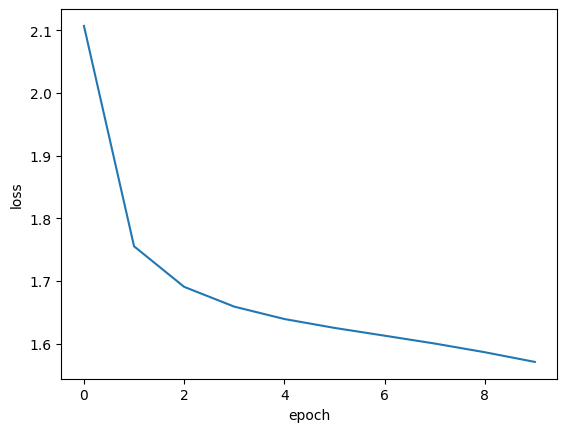

In [34]:
plt.plot(history.history["loss"])

plt.ylabel("loss")

plt.xlabel("epoch")

plt.show()

In [38]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]  # Extracting the layer weight by layer name

print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 50)


In [39]:
query_movies = [
    "Titanic (1997)",

    "Star Wars: Episode IV - A New Hope (1977)",

    "Lion King, The (1994)",

    "Terminator 2: Judgment Day (1991)",

    "Godfather, The (1972)",
]

In [40]:
query_embeddings = []

for movie_title in query_movies:

    movieId = get_movie_id_by_title(movie_title)  # Getting id from the title of the movie
    
    token_id = vocabulary_lookup[movieId]  # Getting index to lookup for embedding task
    
    movie_embedding = movie_embeddings[token_id]  # Getting embedding for query movies
    
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [41]:
similarities = tf.linalg.matmul(

    tf.math.l2_normalize(query_embeddings),  # Normalizing the results of multiplication to get output of dot product on a scale of 0 to 1
    
    tf.math.l2_normalize(movie_embeddings),
    
    transpose_b = True,)

_, indices = tf.math.top_k(similarities, k = 5)

indices = indices.numpy().tolist()


In [42]:
for idx, title in enumerate(query_movies):

    print(title)

    print("".rjust(len(title), "-"))

    similar_tokens = indices[idx]

    for token in similar_tokens:

        similar_movieId = vocabulary[token]

        similar_title = get_movie_title_by_id(similar_movieId)

        print(f"- {similar_title}")

    print()

Titanic (1997)
--------------
- Aladdin (1992)
- Lion King, The (1994)
- Jurassic Park (1993)
- Beauty and the Beast (1991)
- Die Hard: With a Vengeance (1995)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Star Wars: Episode IV - A New Hope (1977)
- Monty Python and the Holy Grail (1975)
- Terminator 2: Judgment Day (1991)
- Matrix, The (1999)
- Pulp Fiction (1994)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Jurassic Park (1993)
- Aladdin (1992)
- Fugitive, The (1993)
- Beauty and the Beast (1991)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Forrest Gump (1994)
- Jurassic Park (1993)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Aliens (1986)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Apocalypse Now (1979)
- Graduate, The (1967)
- Rear Window (1954)
- Citizen Kane (1941)



In [43]:
import pickle

In [44]:
pickle.dump(movies,open('model/movie_list.pkl','wb'))

In [45]:
pickle.dump(similarities,open('model/similarities.pkl','wb'))

In [46]:
pickle.dump(movies,open('model/movie_list.csv','wb'))